# Problem Statement
Data Scientist Task

Given the following data:
Messages (Attached)
Relationships (Attached)

Create a quick model to predict whether or not a message is written for a Birthday and whom it is
being sent to, if it is, class it as a Birthday and pull the relationship data for the user id and display the
age of the recipient from the relationship data.
Output should be something along the lines of:
Birthday - Mum - 65
Not birthday - Uncle - Nan
Birthday - Mum - Nan
ETC
**To be aware of:
1. Please provide the actual code/notebook you used to create this model - preferably through
GitHub or similar.
2. Should be able to run through an example in real time during the interview (just one
message added in with a user id known to have a relationship)
3. Think about latency/speed where possible
4. Try not to focus too much on accuracy at this point in order to save time in completing the
project, however, we will be looking at coding principles to assess
5. Please come prepared to answer technical questions on the model, we will be looking for
crystal clear communication.
6. Not all data will be present for relationship birthdays and so fill with Nan where not possible
to get age.

# Approach

1. Data Exploration
2. Data Cleaning
3. Merging of different datasets
4. Building models, one for birthday.

At the end our input should be of the following json format
{"msg":string,"user_id":string)}



# Data Exploration
1. Basic stats of data for message and relationships
2. Dropping Nulls
3. Identifying what features can be developed


# Libraries

In [5]:
import pandas as pd
import numpy as np
import ast
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error, make_scorer, f1_score
import pickle
from sklearn.pipeline import Pipeline
# from sklearn.externals import joblib
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
import nlpaug.augmenter.word as naw
import random
import stop_words
from nltk.stem import PorterStemmer 
stops =stop_words.get_stop_words(language='en')
wpt = nltk.WordPunctTokenizer()
ps = PorterStemmer() 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/vikash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vikash/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Util Functions

Functions classes used in the modelling process have been listed down here

In [61]:
def extract_all_text(x):
    text_list =[]
    x_eval = eval(x)
    for i in range(len(x_eval)):
        text_list.append(x_eval[i]['text'])
    try:
        return ' '.join(text_list)
    except TypeError:
        return ' '
    
    
def f1(y_true, y_pred):
    """
    F1 score  for y_true and y_predicted
    y_true: True values of array
    y_pred: Predicted values from a model
    """
#     pred1 = [p[0] for p in y_pred]
#     pred2 = [p[1] for p in y_pred]
    f1_rel = f1_score(y_pred,y_true,average='binary')
#     f1_birth = f1_score(pred2,y_true['birthday_trgt'],average='binary')
    return f1_rel
f1_scorer = make_scorer(f1)

#feature cleaner
class FeatureCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, clean=True):
        self.clean = clean
        
    def clean_and_normalize_text_data(self,sentence):
        sentence = re.sub(r'[^a-zA-Z\s]', ' ', sentence, re.I|re.A)
        sentence = sentence.lower()
        sentence = sentence.strip()
        tokens = wpt.tokenize(sentence)
        stemmed_words = [ps.stem(w) for w in tokens]
        #remove stopwords
        filtered_tokens = [token for token in stemmed_words if token not in stops]
        filtered_len =[token for token in filtered_tokens if len(token)>2]
        filtered_len = np.unique(filtered_len)
        sentence = ' '.join(filtered_len)
        return sentence
        

    def transform(self, X,y=None):
        c =pd.Series([self.clean_and_normalize_text_data(x) for x in X])
        return c

    def fit(self, *_):
        return self
    
 #statistical features generated   
class FeatureMultiplierCount(BaseEstimator, TransformerMixin):
    def __init__(self, word_count=True,char_count=True,
                word_density=True,total_length=True,
                capitals=True,caps_vs_length=True,num_exclamation_marks=True,num_question_marks=True,
                num_punctuation=True,num_symbols=True,num_unique_words=True,words_vs_unique=True,
                word_unique_percent=True):
        self.word_count = word_count
        self.total_length = total_length
        self.char_count =char_count
        self.word_density = word_density
        self.capitals = capitals
        self.caps_vs_length = caps_vs_length
        self.num_exclamation_marks=num_exclamation_marks
        self.num_question_marks=num_question_marks
        self.num_punctuation=num_punctuation
        self.num_symbols=num_symbols
        self.num_unique_words = num_unique_words
        self.words_vs_unique = words_vs_unique
        self.word_unique_percent = word_unique_percent

    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        X['word_count'] = X['all_text_new'].apply(lambda x : len(x.split()))
        X['char_count'] = X['all_text_new'].apply(lambda x : len(x.replace(" ","")))
        X['word_density'] = X['word_count'] / (X['char_count'] + 1)

        X['total_length'] = X['all_text_new'].apply(len)
        X['capitals'] = X['all_text_new'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
 
        X['num_exclamation_marks'] =X['all_text_new'].apply(lambda x: x.count('!'))
        X['num_question_marks'] = X['all_text_new'].apply(lambda x: x.count('?'))
        X['num_punctuation'] = X['all_text_new'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
        X['num_symbols'] = X['all_text_new'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
        X['num_unique_words'] = X['all_text_new'].apply(lambda x: len(set(w for w in x.split())))
       
        
        return X[['word_count','char_count','word_density','total_length',
                 'capitals','num_exclamation_marks','num_question_marks',
                 'num_punctuation','num_symbols','num_unique_words']]

    def fit(self, *_):
        return self
    

#modelling pipeline 
def models():
    """
    
    returns three pipelines Random Forest, Adaboost, Gradientboost,SVC
    The scoring function is based on f1_score
    """


    # Random Forest Pipeline
    rf_pipeline = Pipeline([
    ('u1', FeatureUnion([
        ('tfdif_features', Pipeline([('clean',FeatureCleaner()),
             ('tfidf', TfidfVectorizer(max_features=10000,ngram_range=(1,3))),
        ])),
        ('numerical_features',Pipeline([('numerical_feats',FeatureMultiplierCount()),
                                       ('scaler',StandardScaler()),
                                       ])),

    ])),
    ('clf', RandomForestClassifier()),

])
    # Adaboost Pipeline
    AdaBoost_pipeline = Pipeline([
    ('u1', FeatureUnion([
        ('tfdif_features', Pipeline([('clean',FeatureCleaner()),
             ('tfidf', TfidfVectorizer(max_features=10000,ngram_range=(1,3))),
        ])),
        ('numerical_features',Pipeline([('numerical_feats',FeatureMultiplierCount()),
                                       ('scaler',StandardScaler()),
                                       ])),

    ])),
    ('clf', AdaBoostClassifier()),

])
    # Gradient Boost Pipeline
    GRD_pipeline = Pipeline([
    ('u1', FeatureUnion([
        ('tfdif_features', Pipeline([('clean',FeatureCleaner()),
             ('tfidf', TfidfVectorizer(max_features=10000,ngram_range=(1,3))),
        ])),
        ('numerical_features',Pipeline([('numerical_feats',FeatureMultiplierCount()),
                                       ('scaler',StandardScaler()),
                                       ])),

    ])),
    ('clf', GradientBoostingClassifier()),

])
    
    svm_pipeline =Pipeline([
    ('u1', FeatureUnion([
        ('tfdif_features', Pipeline([('clean',FeatureCleaner()),
             ('tfidf', TfidfVectorizer(max_features=10000,ngram_range=(1,3))),
        ])),
        ('numerical_features',Pipeline([('numerical_feats',FeatureMultiplierCount()),
                                       ('scaler',StandardScaler()),
                                       ])),

    ])),
    ('clf', LinearSVC()),

])
    #grid search params for randomforest, adaboost, gradientboost
    grid_params_rf = [{'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [2, 3, 5]}]
    grid_params_adaboost = [{'clf__n_estimators': [10, 50, 100,500], 'clf__learning_rate': [0.5, 0.8, 1.0]}]
    grid_params_grd = [{'clf__n_estimators': [10, 50, 100,500], 'clf__learning_rate': [0.5, 0.8, 1.0],
                            'clf__max_depth': [2, 3, 5]}]
    
    grid_params_svc = [{'clf__C': [1.0,3.0,5.0,10.0],'clf__max_iter':[1000]}]

    #gridsearchcv pipeline for randomforest
    gs_rf = GridSearchCV(estimator=rf_pipeline,
                             param_grid=grid_params_rf,
                             scoring=f1_scorer,
                             cv=5)
    #gridsearchcv pipeline for adaboost
    gs_adaboost = GridSearchCV(estimator=AdaBoost_pipeline,
                                   param_grid=grid_params_adaboost,
                                   scoring=f1_scorer,
                                   cv=5)

    #gridsearchcv pipeline for gradientboost
    gs_grd = GridSearchCV(estimator=GRD_pipeline,
                              param_grid=grid_params_grd,
                              scoring=f1_scorer,
                              cv=5)
    gs_svc = GridSearchCV(estimator=svm_pipeline,
                              param_grid=grid_params_svc,
                              scoring=f1_scorer,
                              cv=5)

    grids = [gs_svc,gs_rf, gs_adaboost, gs_grd]
    # grids = [gs_rf]
    return grids


def clean_and_normalize_text_data(sent):


    
    sent_cleaned = sent.replace('\n','')
    return sent_cleaned

In [6]:
msg_dt = pd.read_csv('Message.csv')
rel = pd.read_csv('relationships.csv')
msg_dt.head()

,user_uuid,message,Unnamed: 2
0,34c87972-e471-4e9b-aefc-d5778a9ae505,"[{""text"":""Dear"",""fontIntegration"":null,""font"":...",NaN
1,117fd8a2-5da2-8b13-6df0-d6766d849093,"[{""text"":""It's going well...."",""fontIntegratio...",NaN
2,f841ccb1-3599-a847-d99b-150a9cb19858,"[{""text"":""Liebe Rita \u0026 Claudia,\n\nliebe ...",NaN
3,117fd8a2-5da2-8b13-6df0-d6766d849093,"[{""text"":""\n\n\n\nYou can't see the chilli and...",NaN
4,d4407500-2e8e-8059-04b5-12adb394ac0d,"[{""text"":""¡Hola papá!\n\nMira qué vistas desde...",NaN


In [7]:
#basic info about message data
msg_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
user_uuid     10000 non-null object
message       10000 non-null object
Unnamed: 2    346 non-null object
dtypes: object(3)
memory usage: 234.5+ KB


In [12]:
print ("UNIQUE USER IDS IN MESSAGE DATA {}".format(msg_dt['user_uuid'].nunique()))
msg_dt['user_uuid'].value_counts()
#the value counts on user ids shows the top users with their number of messages sent.
#lets explore on few users using the relationship data where they most likely use touchnote

UNIQUE USER IDS IN MESSAGE DATA 8600


cb66eaa6-cb85-f180-f2df-b26b91072e76    83
45903ea1-3d81-7f7d-25cd-9acc5c4570f3    35
65dc5608-0fde-241f-e963-9ed255703a83    21
4b2b3920-0498-100e-6022-5d29ac36bdb2    17
3f037c21-dbe1-cb56-c080-1e28d71f0543    16
                                        ..
ba0e326c-e465-419e-b6d1-056683ea2347     1
ebba6f18-3ff4-4748-8f09-4ae7973037d6     1
df841ee5-72ef-8c41-8623-ef6dfc218dcd     1
905bd8ff-56dc-4cb0-b766-61d300544afa     1
b2eb420b-4794-4669-80f3-378d00b9682c     1
Name: user_uuid, Length: 8600, dtype: int64

In [104]:
# we format the message data to extract all the text to be used further in modelling, removing the notorious '\n' also
msg_dt['message_new'] = msg_dt['message'].apply(lambda x: x.replace('null',str(0)))
msg_dt['all_text_new'] = msg_dt['message_new'].apply(lambda x:extract_all_text(x))
msg_dt['all_text_new'] = msg_dt['all_text_new'].apply(lambda x:clean_and_normalize_text_data(x))
msg_dt.head(3)

,user_uuid,message,Unnamed: 2,message_new,all_text,all_text_new
0,34c87972-e471-4e9b-aefc-d5778a9ae505,"[{""text"":""Dear"",""fontIntegration"":null,""font"":...",NaN,"[{""text"":""Dear"",""fontIntegration"":0,""font"":""Bl...",Dear Granddad Get well soon!\n\nWe love you th...,Dear Granddad Get well soon!We love you the wo...
1,117fd8a2-5da2-8b13-6df0-d6766d849093,"[{""text"":""It's going well...."",""fontIntegratio...",NaN,"[{""text"":""It's going well...."",""fontIntegratio...",It's going well....,It's going well....
2,f841ccb1-3599-a847-d99b-150a9cb19858,"[{""text"":""Liebe Rita \u0026 Claudia,\n\nliebe ...",NaN,"[{""text"":""Liebe Rita \u0026 Claudia,\n\nliebe ...","Liebe Rita & Claudia,\n\nliebe und sonnige Grü...","Liebe Rita & Claudia,liebe und sonnige Grüße a..."


In [105]:
#relationship data
rel.head()

,user_uuid,birthday,relationship,relationship_new,birthday_trgt
0,34c87972-e471-4e9b-aefc-d5778a9ae505,17/06/1938 00:00,PARENTS,PARENTS,1
1,117fd8a2-5da2-8b13-6df0-d6766d849093,NaN,MOM,MOM,0
2,f841ccb1-3599-a847-d99b-150a9cb19858,NaN,SISTER_IN_LAW,SISTER_IN_LAW,0
3,117fd8a2-5da2-8b13-6df0-d6766d849093,NaN,MOM,MOM,0
4,d4407500-2e8e-8059-04b5-12adb394ac0d,NaN,DAD,DAD,0


In [106]:
#selecting couple of top users 
users  =['cb66eaa6-cb85-f180-f2df-b26b91072e76','45903ea1-3d81-7f7d-25cd-9acc5c4570f3','65dc5608-0fde-241f-e963-9ed255703a83']
user_relationship = rel[rel['user_uuid'].isin(users)]
user_relationship.groupby(['user_uuid','relationship']).size()


user_uuid                             relationship      
45903ea1-3d81-7f7d-25cd-9acc5c4570f3  BEST_FRIEND_FEMALE     1
                                      Blipfoto Friend        6
                                      COLLEAGUE_FEMALE       1
                                      COLLEAGUE_MALE         1
                                      COUSIN                 3
                                      Church Friend          3
                                      GRANDSON               8
                                      MS Friend              2
                                      Neighbour              1
                                      SISTER                 1
                                      Sister-in-law          1
                                      Visiting Sister        7
65dc5608-0fde-241f-e963-9ed255703a83  BEST_FRIEND_FEMALE    19
                                      FRIEND_FEMALE          2
cb66eaa6-cb85-f180-f2df-b26b91072e76  BEST_FRIEND_FEMALE     

# Insights About The Users, Can it be automated ?

1. 45903ea1-3d81-7f7d-25cd-9acc5c4570f3, the relationship reveals a lot about the age intervals, the user has messaged 8times to 'GRANDSON' the age can be put in the interval of (>45). Though anomalies can always happen. The social structure is also kind of predictive, from the messaging list we can observe anomaly relationship like "Church Friend", in this world of very private relationships, having a "Church Friend" reveals a very wide and friendly network.

2. 65dc5608-0fde-241f-e963-9ed255703a83, in contrast to the above user this particular user has a very secluded list, not much to get from here.

3. cb66eaa6-cb85-f180-f2df-b26b91072e76, this user is probably young "GRANDMA" and "GIRLFRIEND" indicates that and is not married. He was also probably in hospital recently("NURSE").

These insights can be automated in multiple ways:
1. Connecting nodes(relationships) to messages for each user with weights as number of times the message has been sent, in turn entities from these messages are connected to all users.

This type of graphical relationship will allow us to harness these insights in automated way.

Here I would also like to comment that having message_id to each message and connecting the message_id to relationship
would have greater influence. Since a user might message multiple times, and which message corresponds to which relationship will have richer represenatation.


In [107]:
#filtering messages with no text
msg_dt = msg_dt[msg_dt['all_text_new']!=' ']
msg_dt.shape

(9892, 6)

In [108]:
#creating a birthday target variable
def brth_(x):
    split_ = x.split(' ')
    if len(set(split_).intersection(set(['birthday','Birthday'])))>0:
        return 1
    else:
        return 0
msg_dt['target'] = msg_dt['all_text_new'].apply(lambda x:brth_(x))
msg_dt.head()

,user_uuid,message,Unnamed: 2,message_new,all_text,all_text_new,target
0,34c87972-e471-4e9b-aefc-d5778a9ae505,"[{""text"":""Dear"",""fontIntegration"":null,""font"":...",NaN,"[{""text"":""Dear"",""fontIntegration"":0,""font"":""Bl...",Dear Granddad Get well soon!\n\nWe love you th...,Dear Granddad Get well soon!We love you the wo...,0
1,117fd8a2-5da2-8b13-6df0-d6766d849093,"[{""text"":""It's going well...."",""fontIntegratio...",NaN,"[{""text"":""It's going well...."",""fontIntegratio...",It's going well....,It's going well....,0
2,f841ccb1-3599-a847-d99b-150a9cb19858,"[{""text"":""Liebe Rita \u0026 Claudia,\n\nliebe ...",NaN,"[{""text"":""Liebe Rita \u0026 Claudia,\n\nliebe ...","Liebe Rita & Claudia,\n\nliebe und sonnige Grü...","Liebe Rita & Claudia,liebe und sonnige Grüße a...",0
3,117fd8a2-5da2-8b13-6df0-d6766d849093,"[{""text"":""\n\n\n\nYou can't see the chilli and...",NaN,"[{""text"":""\n\n\n\nYou can't see the chilli and...",\n\n\n\nYou can't see the chilli and parsnip c...,You can't see the chilli and parsnip chutney a...,0
4,d4407500-2e8e-8059-04b5-12adb394ac0d,"[{""text"":""¡Hola papá!\n\nMira qué vistas desde...",NaN,"[{""text"":""¡Hola papá!\n\nMira qué vistas desde...",¡Hola papá!\n\nMira qué vistas desde lo alto d...,¡Hola papá!Mira qué vistas desde lo alto del P...,0


In [112]:
#target variables percentage
print (msg_dt['target'].value_counts(normalize=True))
print (msg_dt.shape)
#they seem okay to proceed

0    0.91943
1    0.08057
Name: target, dtype: float64
(9892, 7)


In [136]:
msg_dt = msg_dt[['user_uuid','target','all_text_new']]

# Text Augmentation For Oversampling

In traditional modelling methods we used various oversampling methods after featurization to increase the undersampled classes.
But in modern methods the concept of text augmentation has come around to good usage. The concept of text augmentation is to generate similar meaning text but by replacing new words so that we can have more text data for undersampled classes. We can use the following approaches for text augmentation to generate good relevant text:

1. Replace some words by their synonyms
2. Replace some words by similar words(like love is replaced beloved)
3. Translate the sentence to other language and then translate it back to english

We will be using the second number point. We will pull every undersampled data to atleast 10%(around 200) of the highest class is they are'nt.

In [137]:
#we try to keep the classes which have lower data to atleast 30% i.e 2966 datapoints of the highest class, i.e each class must have 20% of highest class of data.
#for that we augment text using synonyms like below
aug  = naw.SynonymAug(aug_src='wordnet')

In [138]:
def generate_augmented_text(classes):
    df = msg_dt[msg_dt['target']==classes]
    print (df.shape)
    all_ids = df['user_uuid'].to_list()
    max_num =2966
    to_augment = max_num-df.shape[0]
    print (to_augment)
    new_df = pd.DataFrame()
    id_chosen =[]
    i=0
    while i<to_augment:
        id_ = random.choice(list(set(all_ids)-set(id_chosen)))
        sent = df[df['user_uuid']==id_]['all_text_new'].to_list()[0]
        sent_generated = aug.augment(sent)
        temp = pd.DataFrame(columns=['user_uuid','target','all_text_new'],index=[0])
        temp['user_uuid'] =id_
        temp['target'] = classes
      
        temp['all_text_new'] = sent_generated
        new_df = new_df.append(temp)
        i=i+1
    return pd.concat([df,new_df])

In [139]:
aug_class =[1]

new_aug_dt =[]
for cl in aug_class:
    df = generate_augmented_text(cl)
    new_aug_dt.append(df)
train_dt = msg_dt[~msg_dt['target'].isin(aug_class)]

(797, 3)
2169


In [142]:
#after oversampling with text augmentation
all_dt = pd.concat([train_dt,new_aug_dt[0]])
all_dt.shape

(12061, 3)

In [144]:
all_dt['target'].value_counts(normalize=True)

0    0.754083
1    0.245917
Name: target, dtype: float64

In [145]:
#X is the features on which we develop and y is the target variable
y = all_dt.target
X = all_dt.all_text_new

In [146]:
#test and train in 75% and 25% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)


In [147]:
from collections import Counter

Counter(y)

Counter({0: 9095, 1: 2966})

# Featurization And Modelling

1. For featurization we are using the following features:
 1. TFIDF(10000) features with ngram(1,3) 
 2. Counting features
 3. Scaling the count features 
 4. Combining all the features

2. Modelling
   1. We use LinearSVC, Randomforest, Gradientboost, Adaboost to train the model
   2. We run our gridsearchcv with cv=5 
   3. We choose the best model on F1 score
   
All this is being done in a single pipeline(refer models function)

In [148]:
best_acc = 0.0
best_clf = 0
best_gs = ''
grid_dict = {0:'svc',1:'rf',2:'ada',3:'grd'}

    # grid_dict = {0: 'rf'}

grids =models()

for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(X_train, y_train)
    print('Best params: %s' % gs.best_params_)
    print('Best training F1 score  score: %.3f' % gs.best_score_)
    y_pred = gs.predict(X_test)
    print('Test set f1score for best params: %.3f ' % f1(y_test, y_pred))
    if f1(y_test, y_pred) >best_acc:
        best_acc = f1(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\Classifier with best test set f1 score: %s' % grid_dict[best_clf])


Estimator: svc


/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch

Best params: {'clf__C': 1.0, 'clf__max_iter': 1000}
Best training F1 score  score: 0.934
Test set f1score for best params: 0.933 

Estimator: rf
Best params: {'clf__max_depth': 5, 'clf__n_estimators': 10}
Best training F1 score  score: 0.030
Test set f1score for best params: 0.000 

Estimator: ada
Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
Best training F1 score  score: 0.927
Test set f1score for best params: 0.912 

Estimator: grd
Best params: {'clf__learning_rate': 0.5, 'clf__max_depth': 3, 'clf__n_estimators': 10}
Best training F1 score  score: 0.924
Test set f1score for best params: 0.906 
\Classifier with best test set f1 score: svc


In [149]:
# since the best pipeline is with LinearSVC we will run and store it on the complete dataset
svm_pipeline =Pipeline([
    ('u1', FeatureUnion([
        ('tfdif_features', Pipeline([('clean',FeatureCleaner()),
             ('tfidf', TfidfVectorizer(max_features=10000,ngram_range=(1,3))),
        ])),
        ('numerical_features',Pipeline([('numerical_feats',FeatureMultiplierCount()),
                                       ('scaler',StandardScaler()),
                                       ])),

    ])),
    ('clf', LinearSVC()),

])
grid_params_svc = [{'clf__C': [1.0,3.0,5.0,10.0],'clf__max_iter':[1000]}]
#gridsearchcv pipeline for LinearSVC
gs_svc = GridSearchCV(estimator=svm_pipeline,
                              param_grid=grid_params_svc,
                              scoring=f1_scorer,
                              cv=5)

model = gs_svc.fit(X,y)

/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/vikash/miniconda3/envs/pytorch

In [151]:
model.best_score_

0.9259141836256134

In [152]:
import joblib

In [192]:
dump_file = 'best_gs_pipeline_brthday_svc.pkl'


joblib.dump(model.best_estimator_,  dump_file, compress=1)

# with open(model.best_estimator_, 'wb') as file:
#     pickle.dump(best_gs, file)


['best_gs_pipeline_brthday_svc.pkl']

In [212]:
joblib_clf = joblib.load(dump_file)


In [198]:
joblib_clf.predict(X_test)

array([0, 1, 0, ..., 1, 0, 0])

In [199]:
X_test.values[1]

'HAPPY BIRTHDAY! I love you cousin Ella! ! Seminal fluid gambling in my ball quarry with me, we cause sooooo much fun! Anyway has a happy birthday I hope you get lots of cake! ! Love, Aria'

In [205]:
rel_dt = pd.read_csv("relationships.csv")

In [207]:
rel_dt[rel_dt['user_uuid']==inp_json['user_uuid']]

,user_uuid,birthday,relationship
0,34c87972-e471-4e9b-aefc-d5778a9ae505,17/06/1938 00:00,PARENTS
80,34c87972-e471-4e9b-aefc-d5778a9ae505,18/02/1939 00:00,MOM
353,34c87972-e471-4e9b-aefc-d5778a9ae505,14/08/1965 00:00,SISTER
1171,34c87972-e471-4e9b-aefc-d5778a9ae505,14/08/1995 00:00,FRIEND_MALE
1307,34c87972-e471-4e9b-aefc-d5778a9ae505,18/02/1939 00:00,MOM
1308,34c87972-e471-4e9b-aefc-d5778a9ae505,18/02/1938 00:00,MOM
1492,34c87972-e471-4e9b-aefc-d5778a9ae505,22/08/1963 00:00,SISTER
1609,34c87972-e471-4e9b-aefc-d5778a9ae505,17/06/1938 00:00,PARENTS
1848,34c87972-e471-4e9b-aefc-d5778a9ae505,09/08/1957 00:00,BEST_FRIEND_FEMALE


# Using BERT To Finetune

In [223]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [241]:
all_dt.head()

,user_uuid,target,all_text_new
0,34c87972-e471-4e9b-aefc-d5778a9ae505,0,Dear Granddad Get well soon!We love you the wo...
1,117fd8a2-5da2-8b13-6df0-d6766d849093,0,It's going well....
2,f841ccb1-3599-a847-d99b-150a9cb19858,0,"Liebe Rita & Claudia,liebe und sonnige Grüße a..."
3,117fd8a2-5da2-8b13-6df0-d6766d849093,0,You can't see the chilli and parsnip chutney a...
4,d4407500-2e8e-8059-04b5-12adb394ac0d,0,¡Hola papá!Mira qué vistas desde lo alto del P...


In [242]:
train_text, temp_text, train_labels, temp_labels = train_test_split(all_dt['all_text_new'], all_dt['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=all_dt['target'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [244]:
# import BERT-base pretrained model
from transformers import AutoModel, BertTokenizerFast

bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [246]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<AxesSubplot:>

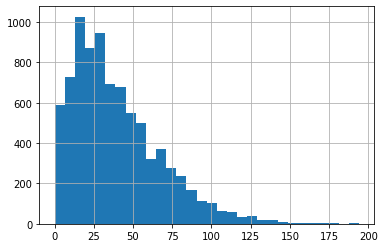

In [247]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [249]:
#if we keep 125 we will cover most of the text
# tokenize and encode sequences in the training set
max_seq_len=125
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [250]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [251]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [252]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [254]:
import torch.nn as nn

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)
        
      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [256]:

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [257]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [258]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)


[0.66305372 2.03323699]


/home/vikash/miniconda3/envs/pytorch_coding/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=4585    0
4160    0
6780    0
7940    0
9920    0
       ..
1192    0
0       1
2641    0
6653    0
4980    0
Name: target, Length: 8442, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [259]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [260]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between a
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
 # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [265]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
#       elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds
    


In [266]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.610
Validation Loss: 0.552

 Epoch 2 / 10
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.588
Validation Loss: 0.542

 Epoch 3 / 10
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.572
Validation Loss: 0.525

 Epoch 4 / 10
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.559
Validation Loss: 0.534

 Epoch 5 / 10
  Batch    50  of    264.
  Batch   100  of    264.
  Batch  

In [269]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [278]:
model.cpu()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [279]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to('cpu'), test_mask.to('cpu'))
  preds = preds.detach().cpu().numpy()

In [282]:
preds

array([1, 1, 0, ..., 1, 0, 1])

In [283]:
# model's performance
from sklearn.metrics import classification_report

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1365
           1       0.48      0.77      0.59       445

    accuracy                           0.74      1810
   macro avg       0.69      0.75      0.70      1810
weighted avg       0.80      0.74      0.76      1810



In [284]:
#ultimately its proven that LinearSVC performs well even than BERT